# Genre Clustering

In [1]:
import pandas as pd

### Merge Spotify Features & Lyrical dataset & Cleaning spotify genres

In [2]:
import statistics as stats
features_lyrics = pd.read_csv('../data/compressed/lyrics_spotify_features.csv')

song_emotions = pd.read_csv('../data/compressed/songs_emotions.csv')

features_lyrics = features_lyrics.merge(song_emotions, on= ['title', 'artist'], how='left')
features_lyrics.drop(columns=['lyrics'], inplace=True)



new_genres =  ["Alternative", "Blues", "Country", "Dance", "Disco", "EDM", "Electronic", "Folk", "Funk",
                  "Hip Hop", "House", "Indie", "Jazz", "Metal", "Motown", "Pop", "R&B", "Rap", "Rock", "Soul"]

ng_map = {g.lower(): g for g in new_genres}

genius_map = {'rb': 'R&B',
              'rock': 'Rock',
              'pop': 'Pop',
              'rap': 'Rap',}


merge_map = {"EDM": "Electronic",
             "House": "Electronic",
             "Indie": "Alternative"}

special_genres = ["Hip Hop", "R&B", "Motown"]

def get_main_genre(genre, genius_genre):
    if not genre or not isinstance(genre, str):
        
    
        if genius_genre:
            return genius_map.get(genius_genre.lower(), genius_genre.title())
        else:
            return ""
    cleaned = genre.replace("[", "").replace("]", "").replace("'", "").replace('"', '')

    genres = [genre.strip() for genre in cleaned.split(',') if genre.strip() != '']
  

    genres_list = []

    for genre in genres:
        genre_clean = genre.replace("_", " ").strip()
        if genre_clean == "":
            continue
        
        base_genre = None
        for special in special_genres:
            if special.lower() in genre_clean.lower():
                base_genre = special
                break
            
        if base_genre is None:
            last = genre_clean.split()[-1].lower()
            base_genre = ng_map.get(last, None)
            
                
        if base_genre in merge_map:
            base_genre = merge_map[base_genre]


        if base_genre is not None:
            genres_list.append(base_genre)

        
    if genres_list:
        final_genres = stats.mode(genres_list) # returns most common genre in a list per song
    else:
        if genius_genre:
            final_genres = genius_map.get(genius_genre.lower(), genius_genre.title())
     

    return final_genres




features_lyrics['mapped_genres'] = features_lyrics.apply(lambda x: get_main_genre(x['spotify_genre_list'], x['genius_genre']), axis=1)
features_lyrics = features_lyrics[features_lyrics['mapped_genres'] != 'Misc']

features_lyrics.drop(columns=['spotify_genre_list', 'genius_genre', 'top_emotion', 'topEmotionWord'], inplace=True)

print(features_lyrics['mapped_genres'].value_counts())
features_lyrics.head()
features_lyrics.columns


mapped_genres
Rock           10365
Pop             7146
Rap             2472
Hip Hop         1687
Metal           1675
Country          775
Soul             756
R&B              641
Folk             574
Electronic       428
Alternative      245
Jazz             221
Funk             203
Disco            135
Dance            114
Blues            104
Motown            30
Name: count, dtype: int64


Index(['title', 'artist', 'year', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'emotions_scores', 'mapped_genres'],
      dtype='object')

## K-means Clustering Implementation

### Preparing Clustering

#### Converting emotion_scores into Dictionary

In [3]:
import ast
import numpy as np
def convert_dictionary(x):
    if isinstance(x,str):
        return ast.literal_eval(x)
    return x
features_lyrics['emotions_scores'] = features_lyrics['emotions_scores'].apply(lambda x : convert_dictionary(x))
features_lyrics['positivity'] = features_lyrics['emotions_scores'].apply(
    lambda x: x.get('positive', 0) if isinstance(x, dict) else 0
)
features_lyrics[features_lyrics['positivity'].isna()]


,title,artist,year,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,emotions_scores,mapped_genres,positivity


#### Fetching Emotion Scores & Cleaning

In [4]:
# extracts emotion scores and stores them in separate columns
emotion_df = pd.json_normalize(features_lyrics['emotions_scores'])
emotion_df = emotion_df.fillna(0.0)
emotion_df.index = features_lyrics.index
features_lyrics = pd.concat([features_lyrics, emotion_df], axis=1)
features_lyrics.columns
features_lyrics[emotion_df.columns]




,anticipation,joy,positive,surprise,trust,anger,disgust,fear,negative,sadness
0,12.0,9.0,29.0,8.0,17.0,12.0,9.0,12.0,22.0,10.0
1,36.0,40.0,44.0,34.0,36.0,39.0,13.0,12.0,22.0,10.0
2,10.0,4.0,16.0,11.0,11.0,11.0,12.0,19.0,32.0,22.0
3,30.0,25.0,37.0,21.0,20.0,27.0,9.0,14.0,26.0,9.0
4,8.0,19.0,28.0,4.0,10.0,23.0,13.0,12.0,26.0,7.0
...,...,...,...,...,...,...,...,...,...,...
27615,6.0,5.0,6.0,2.0,5.0,2.0,1.0,2.0,7.0,4.0
27616,15.0,4.0,8.0,7.0,20.0,4.0,2.0,3.0,6.0,1.0
27617,16.0,12.0,24.0,5.0,19.0,20.0,14.0,23.0,35.0,22.0
27618,2.0,3.0,4.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0


### Spotify Feature Clusters For Each Genre, Top Sentiment and Top Emotion

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score



spotify_features_list = ['danceability', 'energy', 'instrumentalness', 'liveness', 'tempo', 'anticipation', 'surprise', 'trust', 'anger', 'disgust', 'positive', 'loudness', 'speechiness', 'acousticness', 'valence', 'joy', 'fear', 'sadness','positivity']

k = 2
for genre, genre_groups in features_lyrics.groupby('mapped_genres'):
    
    spotify_features = genre_groups[spotify_features_list]

    scaler = StandardScaler()
    spotify_features_scaled = scaler.fit_transform(spotify_features)

    kmeans = KMeans(n_clusters = k, random_state = 42)
    label = kmeans.fit_predict(spotify_features_scaled)
                

    cluster_names = [f"{genre}_cluster_{i+1}" for i in label]

    features_lyrics.loc[genre_groups.index, 'cluster'] = cluster_names




### Analyzing & Classifying The Clusters

In [6]:
print("Number of Clusters", features_lyrics['cluster'].unique().size)
print(features_lyrics['cluster'].unique())
features_lyrics['cluster'].value_counts()


Number of Clusters 34
['Rap_cluster_2' 'Hip Hop_cluster_2' 'Hip Hop_cluster_1' 'Pop_cluster_1'
 'Electronic_cluster_2' 'Rock_cluster_1' 'Rock_cluster_2' 'Soul_cluster_2'
 'Metal_cluster_2' 'Country_cluster_2' 'Pop_cluster_2' 'Folk_cluster_2'
 'Funk_cluster_2' 'Soul_cluster_1' 'Electronic_cluster_1'
 'Metal_cluster_1' 'Disco_cluster_1' 'Rap_cluster_1' 'Blues_cluster_1'
 'Folk_cluster_1' 'R&B_cluster_1' 'R&B_cluster_2' 'Dance_cluster_2'
 'Alternative_cluster_2' 'Disco_cluster_2' 'Funk_cluster_1'
 'Jazz_cluster_1' 'Country_cluster_1' 'Motown_cluster_2' 'Jazz_cluster_2'
 'Alternative_cluster_1' 'Motown_cluster_1' 'Blues_cluster_2'
 'Dance_cluster_1']


cluster
Rock_cluster_2           8135
Pop_cluster_2            5136
Rap_cluster_2            2412
Rock_cluster_1           2230
Pop_cluster_1            2010
Metal_cluster_1          1284
Hip Hop_cluster_1        1106
Soul_cluster_1            604
Hip Hop_cluster_2         581
Country_cluster_1         551
R&B_cluster_1             495
Folk_cluster_2            409
Metal_cluster_2           391
Electronic_cluster_2      371
Country_cluster_2         224
Folk_cluster_1            165
Jazz_cluster_2            155
Soul_cluster_2            152
R&B_cluster_2             146
Alternative_cluster_2     146
Funk_cluster_2            134
Disco_cluster_1           124
Dance_cluster_2           106
Alternative_cluster_1      99
Blues_cluster_1            93
Funk_cluster_1             69
Jazz_cluster_1             66
Rap_cluster_1              60
Electronic_cluster_1       57
Motown_cluster_2           21
Disco_cluster_2            11
Blues_cluster_2            11
Motown_cluster_1            9
Da

In [7]:
cluster_avgs = features_lyrics.groupby('cluster')[spotify_features_list].mean()
cluster_avgs = (cluster_avgs - cluster_avgs.min()) / (cluster_avgs.max() - cluster_avgs.min())
print(cluster_avgs)



                       danceability    energy  instrumentalness  liveness  \
cluster                                                                     
Alternative_cluster_1      0.335704  0.776147          0.083621  0.334989   
Alternative_cluster_2      0.482894  0.359520          0.196372  0.138978   
Blues_cluster_1            0.464453  0.307623          0.056134  0.386942   
Blues_cluster_2            0.847499  0.586114          0.000000  0.000000   
Country_cluster_1          0.520233  0.431295          0.020530  0.286836   
Country_cluster_2          0.526601  0.704077          0.003545  0.275035   
Dance_cluster_1            0.591269  0.982516          0.079797  0.693252   
Dance_cluster_2            0.729568  0.843231          0.187509  0.343631   
Disco_cluster_1            0.676846  0.412637          0.054994  0.350925   
Disco_cluster_2            0.925866  0.462209          0.003444  0.583526   
Electronic_cluster_1       0.961009  0.773412          0.082515  0.421026   

In [8]:
print(features_lyrics['cluster'].value_counts())
features_lyrics.head(10)

features_lyrics.to_csv('../data/processed/lyrics_features_clusters.csv', index=False)

cluster
Rock_cluster_2           8135
Pop_cluster_2            5136
Rap_cluster_2            2412
Rock_cluster_1           2230
Pop_cluster_1            2010
Metal_cluster_1          1284
Hip Hop_cluster_1        1106
Soul_cluster_1            604
Hip Hop_cluster_2         581
Country_cluster_1         551
R&B_cluster_1             495
Folk_cluster_2            409
Metal_cluster_2           391
Electronic_cluster_2      371
Country_cluster_2         224
Folk_cluster_1            165
Jazz_cluster_2            155
Soul_cluster_2            152
R&B_cluster_2             146
Alternative_cluster_2     146
Funk_cluster_2            134
Disco_cluster_1           124
Dance_cluster_2           106
Alternative_cluster_1      99
Blues_cluster_1            93
Funk_cluster_1             69
Jazz_cluster_1             66
Rap_cluster_1              60
Electronic_cluster_1       57
Motown_cluster_2           21
Disco_cluster_2            11
Blues_cluster_2            11
Motown_cluster_1            9
Da

In [9]:
group = features_lyrics.groupby(['cluster', 'year']).size().reset_index(name='count')

table = group.pivot_table(index='year', columns='cluster', values='count', fill_value=0)

with open('../data/processed/clusters.txt', 'w') as f:
    f.write(table.to_string())

### Visualization

### Mappings

In [10]:
print(features_lyrics['cluster'].value_counts())
features_lyrics.head(10)

cluster
Rock_cluster_2           8135
Pop_cluster_2            5136
Rap_cluster_2            2412
Rock_cluster_1           2230
Pop_cluster_1            2010
Metal_cluster_1          1284
Hip Hop_cluster_1        1106
Soul_cluster_1            604
Hip Hop_cluster_2         581
Country_cluster_1         551
R&B_cluster_1             495
Folk_cluster_2            409
Metal_cluster_2           391
Electronic_cluster_2      371
Country_cluster_2         224
Folk_cluster_1            165
Jazz_cluster_2            155
Soul_cluster_2            152
R&B_cluster_2             146
Alternative_cluster_2     146
Funk_cluster_2            134
Disco_cluster_1           124
Dance_cluster_2           106
Alternative_cluster_1      99
Blues_cluster_1            93
Funk_cluster_1             69
Jazz_cluster_1             66
Rap_cluster_1              60
Electronic_cluster_1       57
Motown_cluster_2           21
Disco_cluster_2            11
Blues_cluster_2            11
Motown_cluster_1            9
Da

,title,artist,year,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,joy,positive,surprise,trust,anger,disgust,fear,negative,sadness,cluster
0,Can I Live,JAY-Z,1996,0.628,0.692,-12.365,0.437,0.0823,0.000000,0.1610,...,9.0,29.0,8.0,17.0,12.0,9.0,12.0,22.0,10.0,Rap_cluster_2
1,Money On My Mind,Lil Wayne,2005,0.535,0.772,-6.503,0.370,0.0127,0.000000,0.1100,...,40.0,44.0,34.0,36.0,39.0,13.0,12.0,22.0,10.0,Rap_cluster_2
2,Mr. Carter,Lil Wayne,2008,0.485,0.710,-6.288,0.364,0.0444,0.000000,0.3500,...,4.0,16.0,11.0,11.0,11.0,12.0,19.0,32.0,22.0,Rap_cluster_2
3,C.R.E.A.M.,Wu-Tang Clan,1994,0.479,0.549,-10.551,0.373,0.5700,0.023900,0.1270,...,25.0,37.0,21.0,20.0,27.0,9.0,14.0,26.0,9.0,Hip Hop_cluster_2
4,Barry Bonds,Kanye West,2007,0.480,0.624,-6.131,0.382,0.0451,0.000000,0.3370,...,19.0,28.0,4.0,10.0,23.0,13.0,12.0,26.0,7.0,Rap_cluster_2
5,Fireman,Lil Wayne,2005,0.682,0.723,-4.628,0.211,0.0109,0.000000,0.4060,...,9.0,11.0,7.0,19.0,7.0,0.0,20.0,10.0,5.0,Rap_cluster_2
6,Juicy,The Notorious B.I.G.,1994,0.887,0.767,-4.311,0.295,0.3800,0.000000,0.0527,...,27.0,34.0,22.0,26.0,10.0,7.0,10.0,17.0,11.0,Hip Hop_cluster_2
7,The What,The Notorious B.I.G.,1994,0.622,0.714,-8.244,0.411,0.1910,0.000000,0.1060,...,6.0,18.0,4.0,9.0,21.0,17.0,16.0,27.0,12.0,Hip Hop_cluster_1
8,We Gonna Make It,Jadakiss,2001,0.514,0.961,-3.726,0.347,0.1780,0.000002,0.1460,...,11.0,20.0,9.0,16.0,16.0,14.0,18.0,29.0,10.0,Rap_cluster_2
9,Back That Azz Up,Juvenile,1998,0.874,0.714,-6.664,0.129,0.0155,0.000000,0.0968,...,15.0,19.0,14.0,17.0,29.0,13.0,15.0,60.0,14.0,Rap_cluster_2


In [11]:
group = features_lyrics.groupby(['cluster', 'year']).size().reset_index(name='count')

table = group.pivot_table(index='year', columns='cluster', values='count', fill_value=0)

with open('../data/processed/clusters.txt', 'w') as f:
    f.write(table.to_string())

### Visualization

### Mappings

In [12]:
cluster_names_df = pd.read_csv('../data/raw/cluster_names.csv', header=None, names=['cluster', 'name'], sep=':')

cluster_names_df['cluster'] = cluster_names_df['cluster'].str.strip()
cluster_names_df['name'] = cluster_names_df['name'].str.replace(',', '').str.strip()

# print(cluster_names_df.head())

cluster_mapping = dict(zip(cluster_names_df['cluster'], cluster_names_df['name']))

features_lyrics['Cluster Name'] = features_lyrics['cluster'].map(cluster_mapping)

features_lyrics.head(10)

features_lyrics.to_csv('../data/processed/lyrics_features_clusters.csv', index=False)

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Top 5 Clusters Overall -> I did a heatmap of all five genres and their attributes

# Top 3 Clusters per Genre -> I did a multi-bar chart, where there were three groups of bars representing the three clusters, and in each group a singular bar represented a feature
                                # you have to normalize the values others the bars will come out messed up, also helps to set the lower range to 0.1 so the lower values are still visible)


### Gets the highest feature + emotion per cluster

In [14]:
# Read the CSV file
df = pd.read_csv('../data/raw/cluster_avgs.csv')

# Define feature and emotion columns
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
            'instrumentalness', 'liveness', 'valence', 'tempo']
emotions = ['anticipation', 'joy', 'surprise', 'trust', 'anger', 'disgust', 
            'fear', 'sadness', 'positive']

# Process each cluster
results = []
for _, row in df.iterrows():
    cluster_name = row['cluster']
    
    # Find highest feature
    feature_values = {feat: row[feat] for feat in features}
    highest_feature = max(feature_values, key=feature_values.get)
    highest_feature_value = feature_values[highest_feature]
    
    # Find highest emotion
    emotion_values = {emo: row[emo] for emo in emotions}
    highest_emotion = max(emotion_values, key=emotion_values.get)
    highest_emotion_value = emotion_values[highest_emotion]
    
    results.append({
        'cluster': cluster_name,
        'highest_feature': highest_feature,
        'feature_value': highest_feature_value,
        'highest_emotion': highest_emotion,
        'emotion_value': highest_emotion_value
    })

# Create results dataframe and display
#results_df = pd.DataFrame(results)
#print(results_df.to_string(index=False))

# Save to CSV
#results_df.to_csv('../data/raw/cluster_highest_values.csv', index=False)

### Top 5 Clusters Overall:

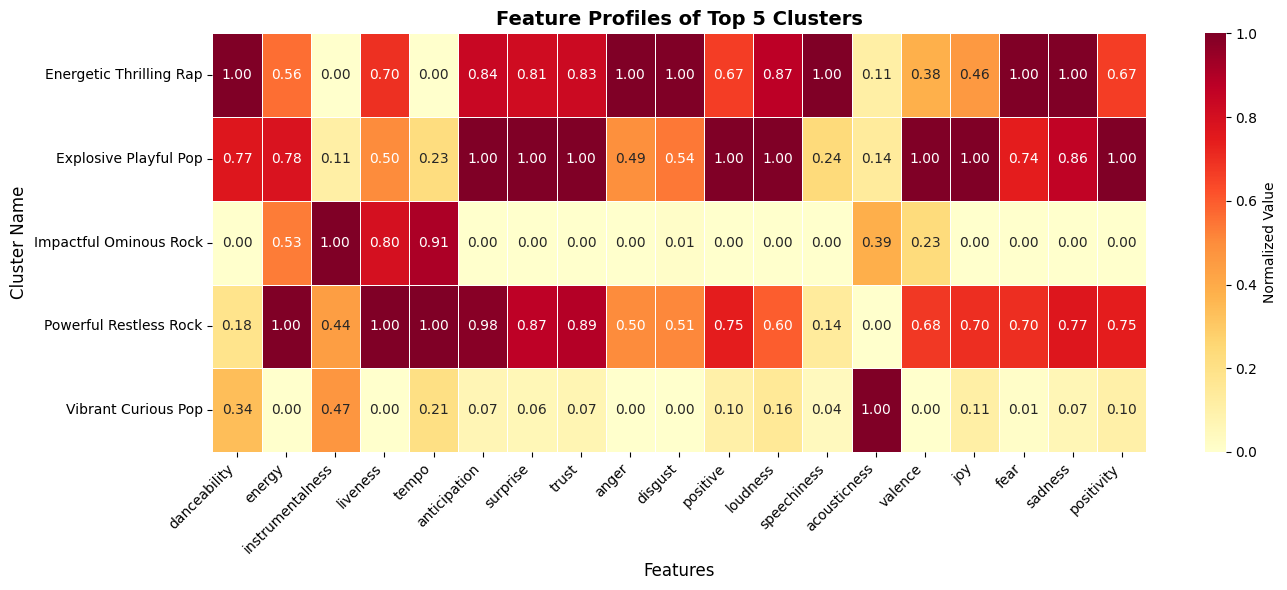

In [15]:
top_5_cluster_names = features_lyrics['Cluster Name'].value_counts().head(5).index.tolist()
top_5_df = features_lyrics[features_lyrics['Cluster Name'].isin(top_5_cluster_names)]

cluster_avgs = top_5_df.groupby('Cluster Name')[spotify_features_list].mean()
cluster_avgs_norm = (cluster_avgs - cluster_avgs.min()) / (cluster_avgs.max() - cluster_avgs.min())

plt.figure(figsize=(14, 6))
sns.heatmap(cluster_avgs_norm, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Normalized Value'}, linewidths=0.5)
plt.title('Feature Profiles of Top 5 Clusters', fontsize=14, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Cluster Name', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Top 3 Genres and their respective clusters:

In [16]:
from sklearn.preprocessing import MinMaxScaler

top_3_genres = features_lyrics['mapped_genres'].value_counts().head(3).index.tolist()
print("Top 3 Genres:", top_3_genres)

cluster_audio_avgs = pd.read_csv('../data/raw/cluster_avgs.csv', index_col='cluster')

Top 3 Genres: ['Rock', 'Pop', 'Rap']


### (a) Rock

Top 2 Clusters for Rock: ['Impactful Ominous Rock', 'Powerful Restless Rock']
Generic cluster names: ['Rock_cluster_2', 'Rock_cluster_1']


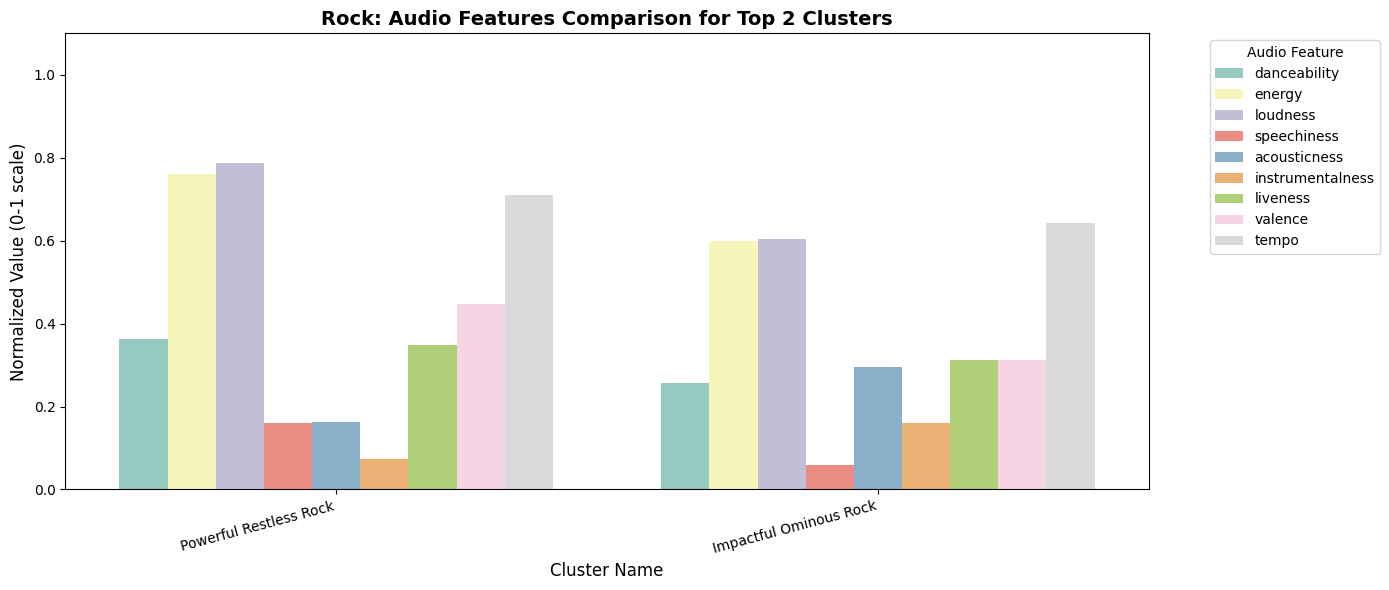

In [17]:
genre = top_3_genres[0]
genre_df = features_lyrics[features_lyrics['mapped_genres'] == genre]
top_2_clusters_genre = genre_df['Cluster Name'].value_counts().head(2).index.tolist()
print(f"Top 2 Clusters for {genre}: {top_2_clusters_genre}")

reverse_cluster_mapping = {v: k for k, v in cluster_mapping.items()}

top_2_clusters_generic = [reverse_cluster_mapping[name] for name in top_2_clusters_genre]
print(f"Generic cluster names: {top_2_clusters_generic}")

cluster_audio_avgs_filtered = cluster_audio_avgs[cluster_audio_avgs.index.isin(top_2_clusters_generic)]

audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
cluster_audio_avgs_filtered = cluster_audio_avgs_filtered[audio_features]

cluster_melted = cluster_audio_avgs_filtered.reset_index()
cluster_melted['cluster'] = cluster_melted['cluster'].map(cluster_mapping)
cluster_melted = cluster_melted.melt(
    id_vars='cluster',
    var_name='Audio Feature',
    value_name='Value'
)

plt.figure(figsize=(14, 6))
sns.barplot(data=cluster_melted, x='cluster', y='Value', 
            hue='Audio Feature', palette='Set3')
plt.xlabel('Cluster Name', fontsize=12)
plt.ylabel('Normalized Value (0-1 scale)', fontsize=12)
plt.title(f'{genre}: Audio Features Comparison for Top 2 Clusters', fontsize=14, fontweight='bold')
plt.ylim(0, 1.1)
plt.xticks(rotation=15, ha='right')
plt.legend(title='Audio Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### (b) Pop

Top 2 Clusters for Pop: ['Vibrant Curious Pop', 'Explosive Playful Pop']
Generic cluster names: ['Pop_cluster_2', 'Pop_cluster_1']


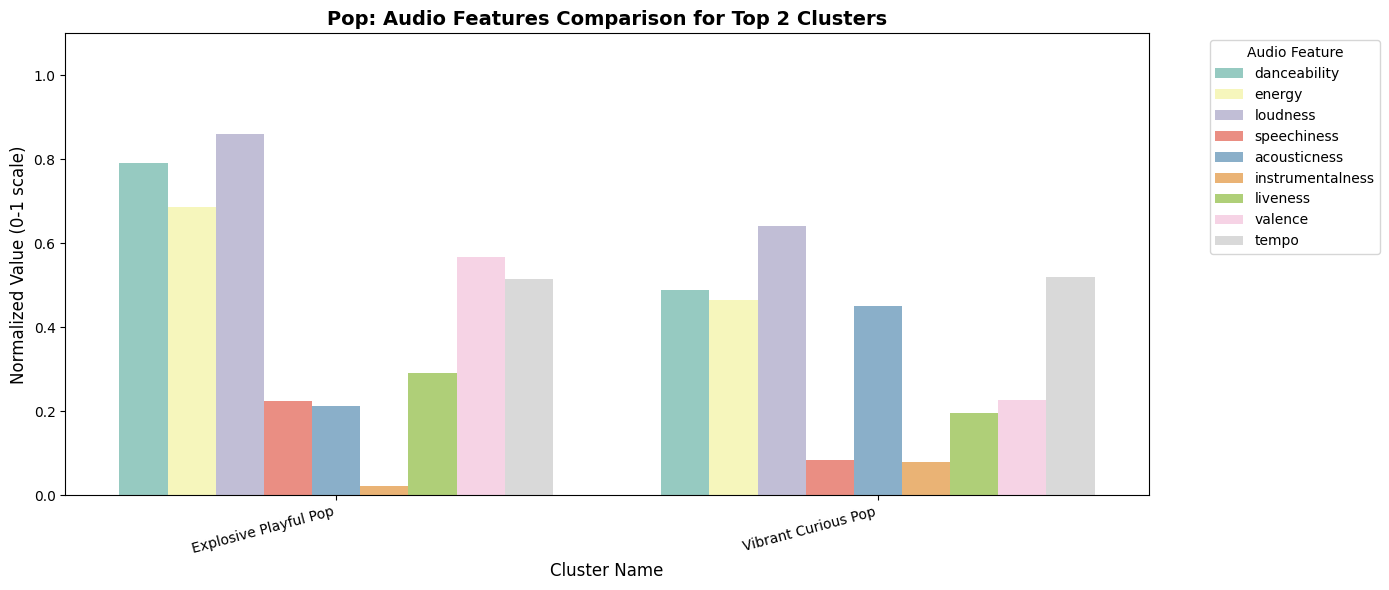

In [18]:
genre = top_3_genres[1]
genre_df = features_lyrics[features_lyrics['mapped_genres'] == genre]
top_2_clusters_genre = genre_df['Cluster Name'].value_counts().head(2).index.tolist()
print(f"Top 2 Clusters for {genre}: {top_2_clusters_genre}")

reverse_cluster_mapping = {v: k for k, v in cluster_mapping.items()}

top_2_clusters_generic = [reverse_cluster_mapping[name] for name in top_2_clusters_genre]
print(f"Generic cluster names: {top_2_clusters_generic}")

cluster_audio_avgs_filtered = cluster_audio_avgs[cluster_audio_avgs.index.isin(top_2_clusters_generic)]

audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
cluster_audio_avgs_filtered = cluster_audio_avgs_filtered[audio_features]

cluster_melted = cluster_audio_avgs_filtered.reset_index()
cluster_melted['cluster'] = cluster_melted['cluster'].map(cluster_mapping)
cluster_melted = cluster_melted.melt(
    id_vars='cluster',
    var_name='Audio Feature',
    value_name='Value'
)

plt.figure(figsize=(14, 6))
sns.barplot(data=cluster_melted, x='cluster', y='Value', 
            hue='Audio Feature', palette='Set3')
plt.xlabel('Cluster Name', fontsize=12)
plt.ylabel('Normalized Value (0-1 scale)', fontsize=12)
plt.title(f'{genre}: Audio Features Comparison for Top 2 Clusters', fontsize=14, fontweight='bold')
plt.ylim(0, 1.1)
plt.xticks(rotation=15, ha='right')
plt.legend(title='Audio Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### (c) Rap

Top 2 Clusters for Rap: ['Energetic Thrilling Rap', 'Instrumental Apprehensive Rap']
Generic cluster names: ['Rap_cluster_2', 'Rap_cluster_1']


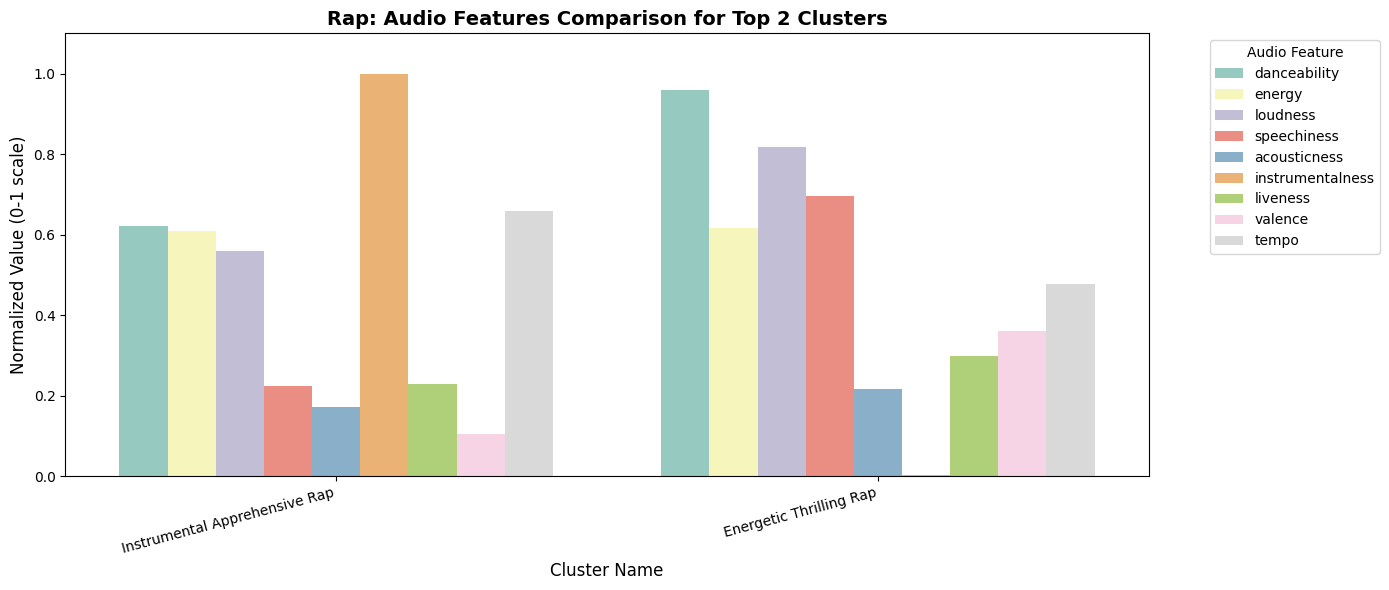

In [19]:
genre = top_3_genres[2]
genre_df = features_lyrics[features_lyrics['mapped_genres'] == genre]
top_2_clusters_genre = genre_df['Cluster Name'].value_counts().head(2).index.tolist()
print(f"Top 2 Clusters for {genre}: {top_2_clusters_genre}")

reverse_cluster_mapping = {v: k for k, v in cluster_mapping.items()}

top_2_clusters_generic = [reverse_cluster_mapping[name] for name in top_2_clusters_genre]
print(f"Generic cluster names: {top_2_clusters_generic}")

cluster_audio_avgs_filtered = cluster_audio_avgs[cluster_audio_avgs.index.isin(top_2_clusters_generic)]

audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
cluster_audio_avgs_filtered = cluster_audio_avgs_filtered[audio_features]

cluster_melted = cluster_audio_avgs_filtered.reset_index()
cluster_melted['cluster'] = cluster_melted['cluster'].map(cluster_mapping)
cluster_melted = cluster_melted.melt(
    id_vars='cluster',
    var_name='Audio Feature',
    value_name='Value'
)

plt.figure(figsize=(14, 6))
sns.barplot(data=cluster_melted, x='cluster', y='Value', 
            hue='Audio Feature', palette='Set3')
plt.xlabel('Cluster Name', fontsize=12)
plt.ylabel('Normalized Value (0-1 scale)', fontsize=12)
plt.title(f'{genre}: Audio Features Comparison for Top 2 Clusters', fontsize=14, fontweight='bold')
plt.ylim(0, 1.1)
plt.xticks(rotation=15, ha='right')
plt.legend(title='Audio Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()